In [1]:
__author__           = "Anzal KS"
__copyright__        = "Copyright 2022-, Anzal KS"
__maintainer__       = "Anzal KS"
__email__            = "anzalks@ncbs.res.in"
from pathlib import Path
import neo.io as nio
import numpy as np
import pandas as pd
from scipy import signal as spy
import matplotlib as mpl
import matplotlib.pyplot as plt
from pprint import pprint
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib.font_manager import FontProperties
import trace_pattern_plot_x_distributed as tpp
import matplotlib.image as mpimg
import multiprocessing
import time
import argparse
import math

In [2]:
"""
Font and color defining functions
"""
y_labels = FontProperties()
y_labels.set_family('sans-serif')
y_labels.set_size('large')
#font.set_style('bold')

sub_titles = FontProperties()
sub_titles.set_family('sans-serif')
sub_titles.set_size('x-large')

main_title = FontProperties()
main_title.set_family('sans-serif')
main_title.set_weight('bold')
main_title.set_size('xx-large')
pre_color = "#FF0000" #pre_color blue 
post_color = "#0000FF" #post_color red 
post_late = "#00FF00" # post late green 

In [3]:
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)


In [4]:
selected_cells = '/Users/anzalks/Documents/Expt_data/Recordings/CA1_recordings/x_spread_30min_recordings/2022_12_09/data'

In [5]:
p = Path(selected_cells)

In [6]:
outdir = p/'cell_stats'
outdir.mkdir(exist_ok=True, parents=True)

In [7]:
def list_folder(p):
    f_list = []
    f_list = list(p.glob('*_cell_*'))
    f_list.sort()
    return f_list

def list_files(p):
    f_list = []
    f_list=list(p.glob('**/*abf'))
    f_list.sort()
    return f_list



In [8]:
"""
1D array and get locations with a rapid rise, N defines the rolling window
"""
def find_ttl_start(trace, N):
    data = np.array(trace)
    data -= data.min()
    data /= data.max()
    pulses = []
    for i, x in enumerate(data[::N]):
        if (i + 1) * N >= len(data):
            break
        y = data[(i+1)*N]
        if x < 0.2 and y > 0.75:
            pulses.append(i*N)
    return pulses


"""
data filter function
"""
def filter_data(data, cutoff, filt_type, fs, order=3):
    b, a = spy.butter(order, cutoff, btype = filt_type, analog=False, output='ba', fs=fs)                                                                                     
    return spy.filtfilt(b, a, data) 

"""
Convert channel names to index as an intiger
"""
def channel_name_to_index(reader, channel_name):
    for signal_channel in reader.header['signal_channels']:
        if channel_name == signal_channel[0]:
            return int(signal_channel[1])

"""
function to find the protocol name for any abf file
"""
def protocol_file_name(file_name):
    f = str(file_name)
    reader = nio.AxonIO(f)
    protocol_name = reader._axon_info['sProtocolPath']
    protocol_name = str(protocol_name).split('\\')[-1]
    protocol_name = protocol_name.split('.')[-2]
    return protocol_name
        
"""
Detects the file name with training data (LTP protocol) in it 
"""
def training_finder(f_name):
    protocol_name = protocol_file_name(f_name)
#    print(f'protocol name = {protocol_name}')
    if 'training' in protocol_name:
        f_name= f_name
    elif 'Training' in protocol_name:
        f_name = f_name
#        print(f'training {f_name}')
    else:
#        print('not training')
        f_name = None
#    print(f'out_ training prot = {f_name}')
    return f_name 

"""
Sort the list of suplied files into pre and post trainign files and return the list 
"""
def pre_post_sorted(f_list):
    found_train=False
    for f_name in f_list:
        training_f = training_finder(f_name)
#        print(f'parsed prot train = {training_f}')
        if ((training_f != None) and (found_train==False)):
            training_indx = f_list.index(training_f)
            # training indx for post will have first element as the training protocol trace
            pre = f_list[:training_indx]
            post = f_list[training_indx:]
#            pprint(f'training file - {training_f} , indx = {training_indx} '
#                f'pre file ={pre} '
#                f'post file = {post} '
#                )
            found_train = True
        elif ((training_f != None) and (found_train==True)):
            no_c_train = f_name
        else:
            pre_f_none, post_f_none, no_c_train = None, None, None
    return [pre, post, no_c_train, pre_f_none, post_f_none ]

"""
Tag protocols with training, patterns, rmp measure etc.. assign a title to the file
"""
def protocol_tag(file_name):
    protocol_name = protocol_file_name(file_name)
    if '12_points' in protocol_name:
        #print('point_protocol')
        title = 'Points'
    elif '42_points' in protocol_name:
        #print('point_protocol')
        title = 'Points'
    elif 'Baseline_5_T_1_1_3_3' in protocol_name:
        #print('pattern protocol')
        title = 'Patterns'
    elif 'patternsx' in protocol_name:
        #print('pattern protocol')
        title = 'Patterns'
    elif 'Training' in protocol_name:
        #print('training')
        title = 'Training pattern'
    elif 'training' in protocol_name:
        #print('training')
        title = 'Training pattern'
    elif 'RMP' in protocol_name:
        #print('rmp')
        title='rmp'
    elif 'Input_res' in protocol_name:
        #print ('InputR')
        title ='InputR'
    elif 'threshold' in protocol_name:
        #print('step_current')
        title = 'step_current'
    else:
        #print('non optical protocol')
        title = None
    return title

"""
Pair files pre and post with point, patterns, rmp etc..
"""
def file_pair_pre_pos(pre_list,post_list):
    point = []
    pattern = [] 
    rmp = []
    InputR = []
    step_current = []
    for pre in pre_list:
        tag = protocol_tag(pre)
#        print(f' tag on the file ={tag}')
        if tag=='Points':
            point.append(pre)
        elif tag=='Patterns':
            pattern.append(pre)
        elif tag =='rmp':
            rmp.append(pre)
        elif tag=='InputR':
            InputR.append(pre)
        elif tag =='step_current':
            step_current.append(pre)
        else:
            tag = None
            continue
    for post in post_list:
        tag = protocol_tag(post)
        if tag=='Points':
            point.append(post)
        elif tag=='Patterns':
            pattern.append(post)
        elif tag=='rmp':
            rmp.append(post)
        elif tag=='InputR':
            InputR.append(post)
        elif tag=='step_current':
            step_current.append(post)
        else:
            tag = None
            continue
#    print(f'point files = {point} '
#           f'pattern files = {pattern}'
#          )
    return [point, pattern,rmp, InputR, step_current]

"""
get cell trace data
"""
def cell_trace(file_name):
    f = str(file_name)
    reader = nio.AxonIO(f)
    channels =reader.header['signal_channels']
    chan_count = len(channels)
    file_id = file_name.stem
    block = reader.read_block(signal_group_mode='split-all')
    segments = block.segments
    sample_trace = segments[0].analogsignals[0]
    sampling_rate = sample_trace.sampling_rate.magnitude
    ti = sample_trace.t_start
    tf = sample_trace.t_stop
    cell_trace_all = []
    for s, segment in enumerate(segments):
        cell = channel_name_to_index(reader,'IN0')
        analogsignals = segment.analogsignals[cell]
        unit = str(analogsignals.units).split()[1]
        trace = np.array(analogsignals)
        cell_trace_all.append(trace) 
        t = np.linspace(0,float(tf-ti),len(trace))
    cell_  = (t,cell_trace_all)
#    print(cell_)
    return [cell_, sampling_rate]



In [9]:
"""
Analysis functions
"""
"""
Get peak events by taking TTL into account
"""
def peak_event(file_name):
    f = str(file_name)
    reader = nio.AxonIO(f)
    channels = reader.header['signal_channels']
    chan_count = len(channels)
    file_id = file_name.stem
    block  = reader.read_block(signal_group_mode='split-all')
    segments = block.segments
    sample_trace = segments[0].analogsignals[0]
    sampling_rate = sample_trace.sampling_rate.magnitude
    ti = sample_trace.t_start
    tf = sample_trace.t_stop
    cell_trace_all = []
    TTL_sig_all = []
    for s, segment in enumerate(segments):
        cell = channel_name_to_index(reader,'IN0')
        analogsignals = segment.analogsignals[cell]
        unit = str(analogsignals.units).split()[1]
        trace = np.array(analogsignals)
        cell_trace_all.append(trace) 
        t = np.linspace(0,float(tf-ti),len(trace))
#    print (f'IN0 = {cell_trace_all}')
    for s, segment in enumerate(segments):
        cell = channel_name_to_index(reader,'FrameTTL')
        analogsignals = segment.analogsignals[cell]
        unit = str(analogsignals.units).split()[1]
        trace = np.array(analogsignals)
        TTL_sig_all.append(trace) 
        t = np.linspace(0,float(tf-ti),len(trace))
#    print (f' TTL = {TTL_sig_all}')
    ttl_av = np.average(TTL_sig_all,axis=0 )
    ttl_xi= find_ttl_start(trace, 3)
    ttl_xf = (ttl_xi+0.075*sampling_rate).astype(int)
    bl_xf = (ttl_xi-0.005*sampling_rate).astype(int)
    bl_xi = (bl_xf-0.01*sampling_rate).astype(int)
    cell_trace  = np.average(cell_trace_all, axis =0)
    cell_trace_base_line = np.mean(cell_trace[0:int(0.2*sampling_rate)] )
    cell_trace_av = cell_trace - cell_trace_base_line
    cell_trace_b_sub = cell_trace_all-cell_trace_base_line
    event_av = []
    events = []
    pat_trace =[]
    for i,ti in enumerate(ttl_xi): 
        event_av.append(np.max(cell_trace_av[ttl_xi[i]:ttl_xf[i]]))
        pattern = []
        pt_trace = []
        for n, ni in enumerate(cell_trace_all):
            r_t =ni[ttl_xi[i]:ttl_xf[i]]
            b_l = np.mean(ni[bl_xi[i]:bl_xf[i]],axis=0)
            bl_t = ni[bl_xi[i]:bl_xf[i]]-b_l
            p_t = r_t-b_l
            pat_t = ni[bl_xi[i]:ttl_xf[i]]
            pt_trace.append(pat_t)
            pt_max = np.max(p_t)
            pattern.append(pt_max)
        events.append(pattern)
        pat_trace.append(pt_trace)
    #print(f'peak_event worked, events ={events}')
    return [event_av, events,pat_trace]



"""
Raw epsp response amplitude values 
"""

def raw_peak_dist(points_or_pattern_file_set_abf):
    global epsp_post_raw
    pre_f = points_or_pattern_file_set_abf[0]
    post_f = points_or_pattern_file_set_abf[1:]
    epsp_pre = peak_event(pre_f)[1]

    epsp_pre_raw = peak_event(pre_f)[2]
    epsp_post = []
    epsp_post_raw = []
    for p in post_f:
        epsp_post_raw.append(peak_event(p)[2])
        epsp_post.append(peak_event(p)[1])
    epsp_raw = [epsp_pre_raw,epsp_post_raw]
    epsp_events = [epsp_pre,epsp_post,epsp_raw]
    #print(f'raw_peak_dist_worked')
    return epsp_events


        
    
    

In [10]:
"""
single cell functions
"""
"""
pair pre and post, points and patterns for each cell.
"""
def file_pair(cell_path): 
    cell_id = str(cell_path.stem)
    abf_list = list_files(cell_path)
    sorted_f_list = pre_post_sorted(abf_list)
    pre_f_list = sorted_f_list[0]
    post_f_list = sorted_f_list[1][1:]
    training_f = sorted_f_list[1][0]
    no_c_train = sorted_f_list[2]
    paired_list = file_pair_pre_pos(pre_f_list, post_f_list)
    paired_points = paired_list[0]
    paired_patterns = paired_list[1]
    return [paired_points,paired_patterns]


"""
series resistance changes for X distributed patterns
"""

def series_res_cell(cell_path):
    files_paired = file_pair(cell_path)
    points,patterns = files_paired[0],files_paired[1]
    point_pre, point_post = points[0],points[1]
    pattern_pre,pattern_post =patterns[0],patterns[1]
    sampling_rate = cell_trace(point_pre)[1]
    protocol_name = protocol_file_name(point_pre)
#    print(f'protocol name = {protocol_name}')
    if '42_points' in protocol_name:
        points_t_start, points_t_end = 11.8,12.225
        pattern_t_start, pattern_t_end =11.4,11.7        
    elif '12_points' in protocol_name:
        points_t_start, points_t_end = 4.0,4.55
        pattern_t_start, pattern_t_end =8.4,8.75
    else:
        print(f'something off with protocol file name')
    injected_current = current_injected(point_pre)
    series_r_point_pre = series_res_measure(point_pre,injected_current,points_t_start,points_t_end,sampling_rate)
    series_r_point_post = series_res_measure(point_post,injected_current,points_t_start,points_t_end,sampling_rate)
    series_r_pattern_pre = series_res_measure(pattern_pre,injected_current,pattern_t_start,pattern_t_end,sampling_rate)
    series_r_pattern_post = series_res_measure(pattern_post,injected_current,pattern_t_start,pattern_t_end,sampling_rate)
    series_r_point = [series_r_point_pre,series_r_point_post]
    series_r_patern = [series_r_pattern_pre,series_r_pattern_post]
    series_r = [series_r_point,series_r_patern]
    return series_r

"""
pickup the changes in series resistances across recordings in the cell.
returns the difference in series resistance change across different protocols
give a percentage change from begining to end of the protocol.
"""
def series_r_shift(cell_path):
    series_r=series_res_cell(cell_path)
    point_pre = series_r[0][0]
    point_pre_mean = np.mean(point_pre)
    point_post = series_r[0][1]
    point_post_mean = np.mean(point_post)
    pattern_pre = series_r[1][0]
    pattern_pre_mean = np.mean(pattern_pre)
    pattern_post = series_r[1][1]
    pattern_post_mean = np.mean(pattern_post)
    point_sr_diff = point_post_mean-point_pre_mean
    pattern_sr_diff = pattern_post_mean-pattern_pre_mean
    cel_sr_diff= point_post_mean-point_pre_mean # first and last protocol is point based.
    pec_change = np.around((((np.abs(cel_sr_diff))/np.abs(point_pre_mean))*100),2)
    sr_diff = np.abs([point_sr_diff,pattern_sr_diff,cel_sr_diff])
    return [sr_diff,pec_change]

"""
take in the cell path and list down the Vms for different files
"""

def vm_shift_cell(cell_path):
    files_paired = file_pair(cell_path)
    points = files_paired[0]
    patterns = files_paired[1]
    vm_shift_points_pre = vm_shift(points[0])
    vm_shift_points_post = vm_shift(points[1])
    vm_shift_patterns_pre = vm_shift(patterns[0])
    vm_shift_patterns_post = vm_shift(patterns[1])
    vm_s_point = [vm_shift_points_pre,vm_shift_points_post]
    vm_s_pattern = [vm_shift_patterns_pre,vm_shift_patterns_post]
    vm_s_cell = np.mean(np.abs(vm_shift_points_post-vm_shift_points_pre))
    return vm_s_cell

"""
Take in cell path and calculate the amount of plasticity: percentage increase
in amplitude.
"""
def plasticity_test_cell(cell_path):
    global raw_pattern_pre
    files_paired = file_pair(cell_path)
    points = files_paired[0]
    patterns = files_paired[1]
    
    epsps_points = raw_peak_dist(points)
    epsps_points_pre = epsps_points[0]
    epsps_points_post = epsps_points[1]
    #raw_points_pre = epsps_points[2][0]
    #raw_points_post = epsps_points[2][1]
    raw_points =[epsps_points_pre,epsps_points_post]
    #print(f'for points epsp pre = {epsps_points_pre},##### epsp post = {epsps_points_post}')
    change_epsp_point = np.mean(epsps_points_post,axis=0)-np.mean(epsps_points_pre,axis=0)
    perc_change_point = np.around(((change_epsp_point/np.mean(epsps_points_pre,axis=0))*100),1)
    #print(f' point change= {perc_change_point}')
    
    epsps_patterns = raw_peak_dist(patterns)
    epsps_patterns_pre = epsps_patterns[0]
    epsps_patterns_post = epsps_patterns[1]
    raw_pattern_pre = epsps_patterns[2][0]
    #raw_pattern_post = epsps_patterns[2][1]
    raw_patterns = [epsps_patterns_pre,epsps_patterns_post]
    #print(f'for points epsp pre = {epsps_patterns_pre},##### epsp post = {epsps_patterns_post}')
    change_epsp_pattern = np.mean(epsps_patterns_post,axis=0)-np.mean(epsps_patterns_pre,axis=0)
    perc_change_pattern = np.around(((change_epsp_pattern/np.mean(epsps_patterns_pre,axis=0))*100),1)
    #print(f'pattern change = {perc_change_pattern}')

    epsp_per = [perc_change_point,perc_change_pattern,raw_points,raw_patterns]
    return epsp_per
    

In [11]:
"""
Functions used across cells
"""



'\nFunctions used across cells\n'

In [12]:

    
"""
event plotting 
"""
def plasticity_raw_trace_plot(cell_path):
    #global sp_n
    #global raw_points_post
    files_paired = file_pair(cell_path)
    points = files_paired[0]
    patterns = files_paired[1]
    
    epsps_points = raw_peak_dist(points)
    raw_points_pre = epsps_points[2][0]
    raw_points_post = epsps_points[2][1]

    
    epsps_patterns = raw_peak_dist(patterns)
    raw_pattern_pre = epsps_patterns[2][0]
    raw_pattern_post = epsps_patterns[2][1]
    
    #plot epsps pre vs post ptterns
    sp_n = np.shape(raw_pattern_pre)[0]
    sp_n = int(math.ceil(sp_n / 2) * 2)
    #fig, axs = plt.subplots(2,int(sp_n/2), figsize = (12,4)) #for x speard patterns
    fig, axs = plt.subplots(2,int(sp_n/2), figsize = (12,4)) #for non_x
    
    axs=axs.flatten()
    
    for p,i in enumerate(raw_pattern_pre):
        for n,x in enumerate(i):
            bl = np.mean(x[100:300])
            x = x-bl
            if ((p+1==len(raw_pattern_pre))and(n+1==len(i))):
                axs[p].plot(x,color=pre_color, label='pre training')
            else:
                axs[p].plot(x,color=pre_color)

    for a,b in enumerate(raw_pattern_post):
        for p,i in enumerate(b):
            for n,x in enumerate(i):
                bl = np.mean(x[100:300])
                x = x-bl
                #print(bl)
                if n+1==len(i):
                    t_label =f'time = {((a+1)*5)-5} mins'
                else:
                    t_label='_nolegend_'
                #axs[p].plot(x,color=f'C{a}',alpha=0.5, label=t_label)
                axs[p].plot(x,color=colorFader(post_color,post_late,a/len(raw_points_post)),alpha=0.3)
                if p+1==len(b):
                    axs[p].plot(x,color=colorFader(post_color,post_late,a/len(raw_points_post)),alpha=0.3,label=t_label)
            axs[p].set_title(f'frame no = {p+1}')
            if ((a+1==int(len(raw_pattern_post)))and (p+1==len(b))):
                fig.legend(loc='upper center',bbox_to_anchor =(0.5, -0.02), ncol = 4)
            else:
                continue
    plt.suptitle(f'Raw response for patterns: {cell_path.stem}')
    plt.ylabel('mV')
    plt.tight_layout()
    plt.show(fig)
    plt.close(fig)
    
    #plot epsps pre vs post  points
    sp_n = np.shape(raw_points_pre)[0]
    sp_n = int((math.ceil(sp_n/2))*2)
    print(f' sp = {sp_n}')
    #fig, axs = plt.subplots(5,int(sp_n/4), figsize = (15,7)) # for non x_spread
    fig, axs = plt.subplots(2,int(sp_n/2), figsize = (12,3),layout="constrained") # for x_spread
    axs=axs.flatten()
    
    for p,i in enumerate(raw_points_pre):
        for n,x in enumerate(i):
            bl = np.mean(x[100:300])
            x = x-bl
            if ((p+1==len(raw_pattern_pre))and(n+1==len(i))):
                axs[p].plot(x,color=pre_color, label='pre training')
            else:
                axs[p].plot(x,color=pre_color)

    for a,b in enumerate(raw_points_post):
        for p,i in enumerate(b):
            for n,x in enumerate(i):
                bl = np.mean(x[100:300])
                x = x-bl
                #print(bl)
                if n+1==len(i):
                    t_label =f'time = {((a+1)*5)-5} mins'
                else:
                    t_label='_nolegend_'
                #axs[p].plot(x,color=f'C{a}',alpha=0.5, label=t_label)
                axs[p].plot(x,color=colorFader(post_color,post_late,a/len(raw_points_post)),alpha=0.3)
                if p+1==len(b):
                    axs[p].plot(x,color=colorFader(post_color,post_late,a/len(raw_points_post)),alpha=0.3,label=t_label)
            axs[p].set_title(f'frame no = {p+1}')
            if ((a+1==int(len(raw_pattern_post)))and (p+1==len(b))):
                fig.legend(loc='upper center',bbox_to_anchor =(0.5, -0.02), ncol = 4)
            else:
                continue
    plt.suptitle(f'Raw response for points: {cell_path.stem}')
    plt.ylabel('mV')
    #plt.tight_layout()#rect=[0, 0.03, 1, 0.95])#pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show(fig)
    plt.close(fig)   
    raw_pattern_pre_plot =raw_pattern_pre
    return 


In [13]:
def plasticity_raw_trace_average_plot(cell_path):
    #global sp_n
    #global raw_points_post
    files_paired = file_pair(cell_path)
    points = files_paired[0]
    patterns = files_paired[1]
    
    epsps_points = raw_peak_dist(points)
    raw_points_pre = epsps_points[2][0]
    raw_points_post = epsps_points[2][1]

    
    epsps_patterns = raw_peak_dist(patterns)
    raw_pattern_pre = epsps_patterns[2][0]
    raw_pattern_post = epsps_patterns[2][1]
    
    #plot epsps pre vs post ptterns
    sp_n = np.shape(raw_pattern_pre)[0]
    sp_n = int(math.ceil(sp_n / 2) * 2)
    #fig, axs = plt.subplots(2,int(sp_n/2), figsize = (12,4)) #for x speard patterns
    fig, axs = plt.subplots(2,int(sp_n/2), figsize = (12,4)) #for non_x
    
    axs=axs.flatten()
    
    for p,i in enumerate(raw_pattern_pre):
        trace_av = []
        for n,x in enumerate(i):
            trace_av.append(x)
        trace_av = np.mean(trace_av,axis=0)    
        bl = np.mean(trace_av[100:300])
        trace_av= trace_av-bl
        if p+1==len(raw_pattern_pre):
            axs[p].plot(trace_av,color=pre_color, label ='Pre training')
        else:
            axs[p].plot(trace_av,color=pre_color)

    for a,b in enumerate(raw_pattern_post):
        for p,i in enumerate(b):
            trace_av = []
            for n,x in enumerate(i):
                trace_av.append(x)
            if p+1==len(b):
                t_label =f'time = {((a+1)*5)-5} mins'
            else:
                t_label='_nolegend_'
            y =np.mean(trace_av,axis=0)
            bl = np.mean(y[100:300])
            y = y-bl
            if p+1==len(b):
                t_label =f'time = {((a+1)*5)-5} mins'
                axs[p].plot(y,color=colorFader(post_color,post_late,a/len(raw_points_post)),alpha=0.8,label=t_label)
            else:
                t_label='_nolegend_'
                axs[p].plot(y,color=colorFader(post_color,post_late,a/len(raw_points_post)),alpha=0.8,label=t_label)
                continue
            axs[p].set_title(f'frame no = {p+1}')
            if ((a+1==int(len(raw_pattern_post)))and (p+1==len(b))):
                fig.legend(loc='upper center',bbox_to_anchor =(0.5, -0.02), ncol = 5)
            else:
                continue
    plt.suptitle(f'Average response for patterns: {cell_path.stem}')
    plt.ylabel('mV')
    plt.tight_layout()
    plt.show(fig)
    plt.close(fig)
    
    #plot epsps pre vs post  points
    sp_n = np.shape(raw_points_pre)[0]
    sp_n = int((math.ceil(sp_n/2))*2)
    print(f' sp = {sp_n}')
    #fig, axs = plt.subplots(5,int(sp_n/4), figsize = (15,7)) # for non x_spread
    fig, axs = plt.subplots(2,int(sp_n/2), figsize = (12,3),layout="constrained") # for x_spread
    axs=axs.flatten()
    
    for p,i in enumerate(raw_points_pre):
        trace_av = []
        for n,x in enumerate(i):
            trace_av.append(x)
        trace_av = np.mean(trace_av,axis=0)    
        bl = np.mean(trace_av[100:300])
        trace_av= trace_av-bl
        if p+1==len(raw_pattern_pre):
            axs[p].plot(trace_av,color=pre_color, label ='Pre training')
        else:
            axs[p].plot(trace_av,color=pre_color)

    for a,b in enumerate(raw_points_post):
        for p,i in enumerate(b):
            trace_av = []
            for n,x in enumerate(i):
                trace_av.append(x)
            if p+1==len(b):
                t_label =f'time = {((a+1)*5)-5} mins'
            else:
                t_label='_nolegend_'
            y =np.mean(trace_av,axis=0)
            bl = np.mean(y[100:300])
            y = y-bl
            if p+1==len(b):
                t_label =f'time = {((a+1)*5)-5} mins'
                axs[p].plot(y,color=colorFader(post_color,post_late,a/len(raw_points_post)),alpha=0.8,label=t_label)
            else:
                t_label='_nolegend_'
                axs[p].plot(y,color=colorFader(post_color,post_late,a/len(raw_points_post)),alpha=0.8,label=t_label)
                continue
            axs[p].set_title(f'frame no = {p+1}')
            if ((a+1==int(len(raw_pattern_post)))and (p+1==len(b))):
                fig.legend(loc='upper center',bbox_to_anchor =(0.5, -0.02), ncol = 5)
            else:
                continue
    plt.suptitle(f'Average response for points: {cell_path.stem}')
    plt.ylabel('mV')
    #plt.tight_layout()#rect=[0, 0.03, 1, 0.95])#pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show(fig)
    plt.close(fig)   
    raw_pattern_pre_plot =raw_pattern_pre
    return 


In [14]:
def plot_raw(f):
    f = str(f)
    reader = nio.AxonIO(f)
    channels = reader.header['signal_channels']
    chan_count = len(channels)
    block  = reader.read_block(signal_group_mode='split-all')
    segments = block.segments
    sample_trace = segments[0].analogsignals[0]
    sampling_rate = sample_trace.sampling_rate
    ti = sample_trace.t_start
    tf = sample_trace.t_stop
    total_time = int(tf-ti)
    protocol_raw = reader.read_raw_protocol()
    protocol_raw = protocol_raw[0]
    print(total_time)
    unit = str(sample_trace.units).split()[1]
#        print(unit)
    fig, axs = plt.subplots(chan_count,2,figsize=(15,6),sharex='col')
    for i in range(chan_count):
        trace_average = []
        for s, segment in enumerate(segments):
            analogsignals = segment.analogsignals[i]
            unit = str(analogsignals.units).split()[1]
            trace = np.array(analogsignals)
            trace_average.append(trace)
            t = np.linspace(0,float(tf-ti),len(trace))
            axs[i][0].plot(t,trace,alpha=0.7,linewidth=2, label = f'trial - {s+1}')
        axs[0][0].set_title('recording')
        axs[0][0].set_ylabel(unit)
        axs[3][0].set_xlabel('time(s)')
    
    
        for n in protocol_raw:
            p = n[i]
            axs[i][1].plot(t,p)
        axs[0][1].set_title('protocol')
    plt.show()

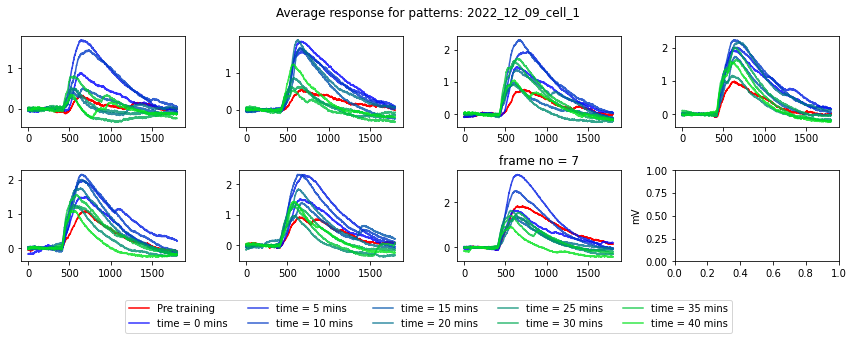

 sp = 12


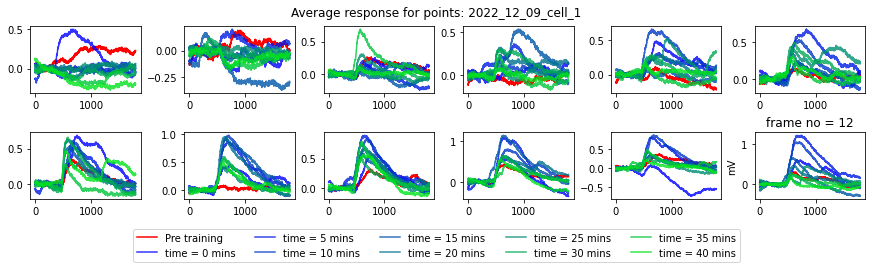

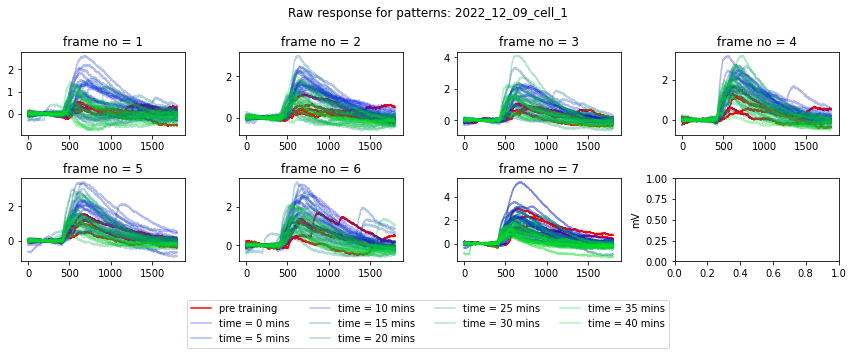

 sp = 12


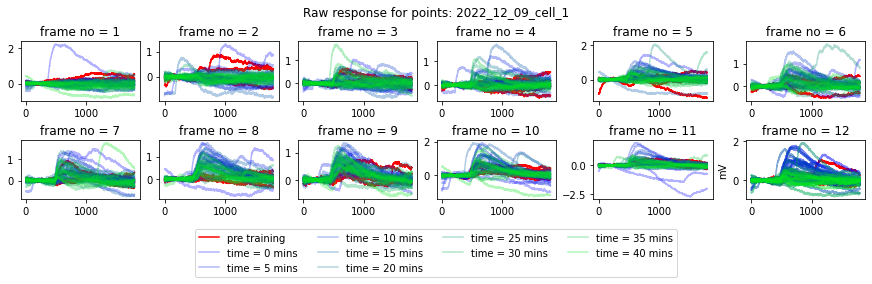

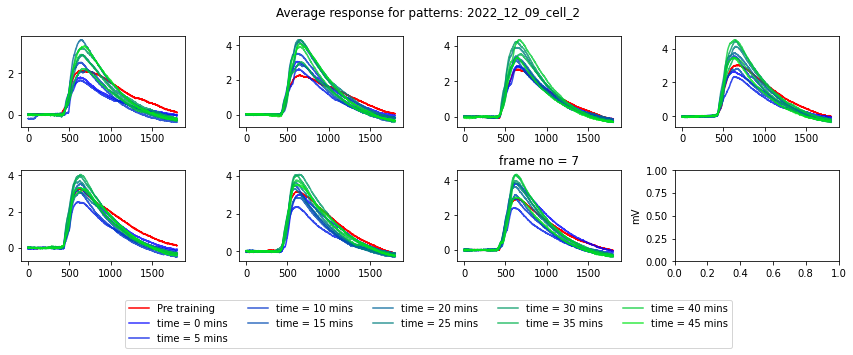

 sp = 12


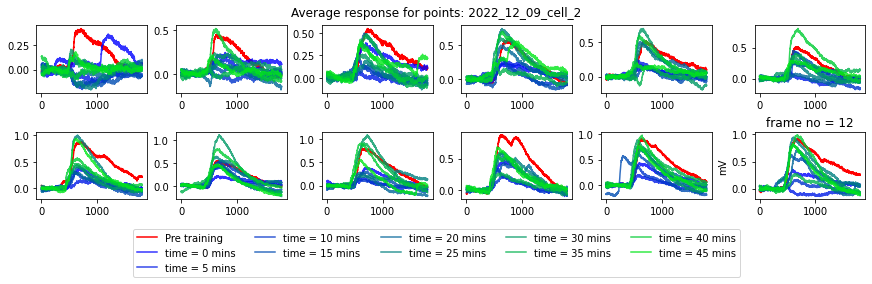

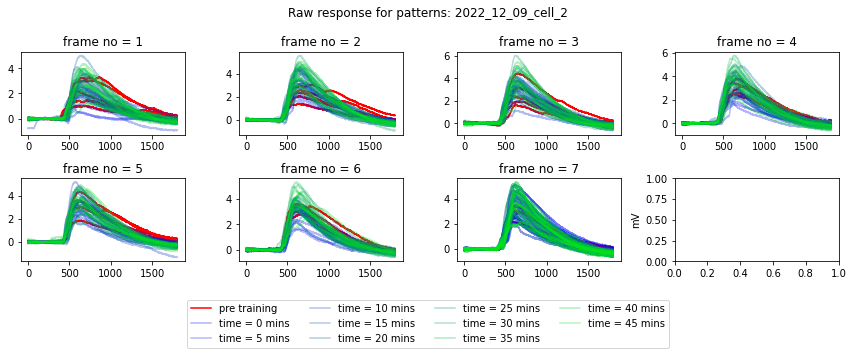

 sp = 12


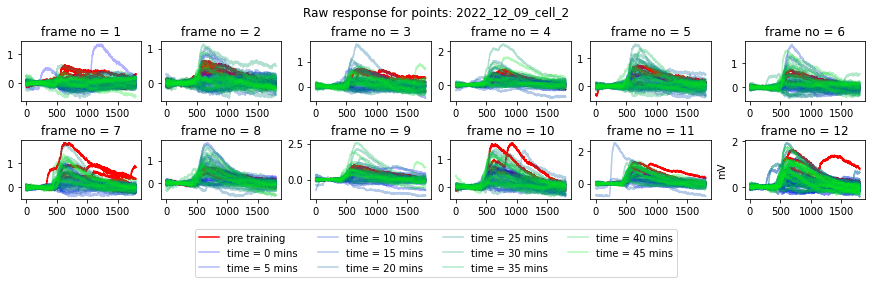

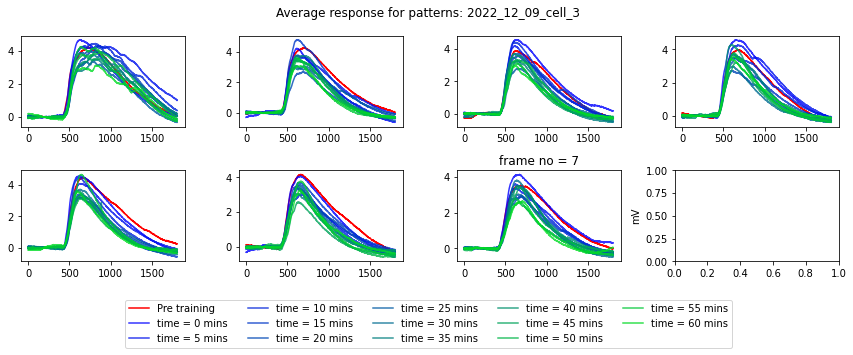

 sp = 12


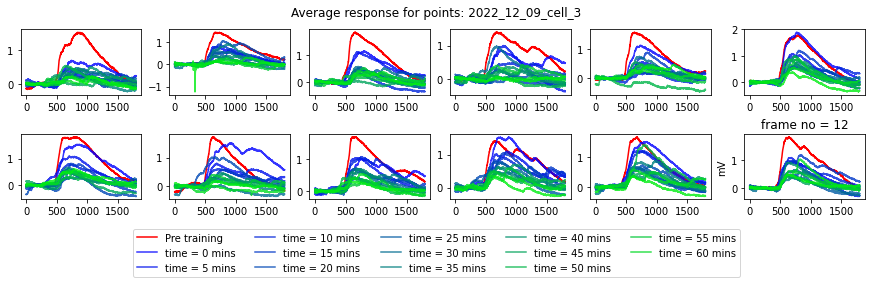

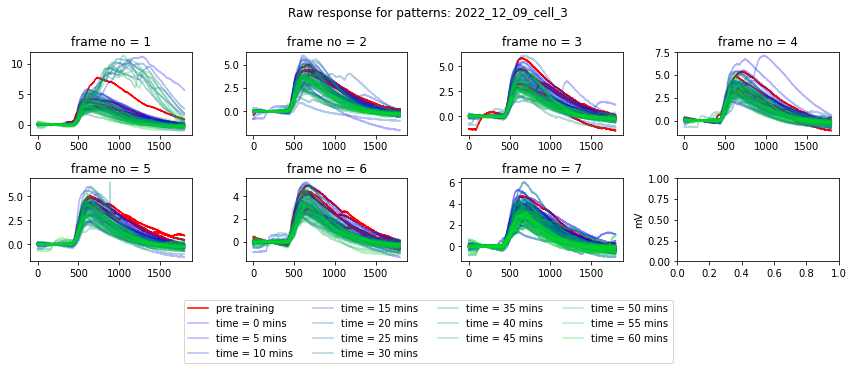

 sp = 12


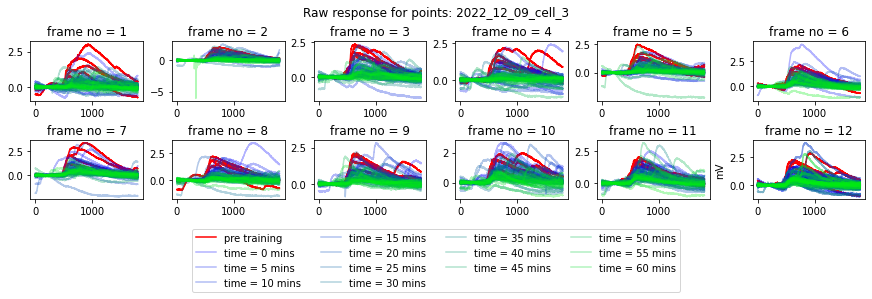

In [15]:
cells = list_folder(p)

#paired = []
for c in cells:
    plasticity_raw_trace_average_plot(c)
    plasticity_raw_trace_plot(c)

